This programm will learn and execute sequence tagging based on LSTM with a following CNN-maxpooling-layer for feature selection.

This programm depends on Tensorflow, Keras and Scikit-Learn version 0.20

The link to the code is: https://github.com/kamalkraj/Named-Entity-Recognition-with-Bidirectional-LSTM-CNNs


But the code was outdated due to scikit-learn >0.16.
I updated those problems so it works again.
Also the code was split in 3 python files for preprocessing, model and validation which I recombined in this file.

Additional a more simple model was added which contains a lstm only. the selection is defined by the cell which will you run. there are more details in the corresponding section

In [1]:
import numpy as np
import random
import zipfile

import matplotlib.pyplot as plt
import tensorflow as tf

from keras.initializers import RandomUniform
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,MaxPooling1D,Flatten,concatenate
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import Progbar

Using TensorFlow backend.


In [2]:
# define pathes to download needed data
  # datasets
path_train = 'https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/data/conll2003/en/train.txt'
path_test = 'https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/data/conll2003/en/test.txt'
path_valid = 'https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/data/conll2003/en/valid.txt'

  # path to matrix which already contains a mapping from words to vectors. Can be extended locally
path_glove = 'http://nlp.stanford.edu/data/glove.6B.zip'

### Define Methods to preprocess Datasets

In [3]:
# define how the file with the input-content looks like, build sentences from the file, 
# per line there will be one sentence. Each word is tagged. The sentences
# with later be the train-examples while the tagging will be the learned target

def readfile(filename):
    '''
    read file
    return format :
    [ ['EU', 'B-ORG'], ['rejects', 'O'], ['German', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['British', 'B-MISC'], ['lamb', 'O'], ['.', 'O'] ]
    '''
    f = open(filename)
    sentences = []
    sentence = []
    for line in f:
        if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        sentence.append([splits[0],splits[-1]])

    if len(sentence) >0:
        sentences.append(sentence)
        sentence = []
    return sentences

In [4]:
# define the casing, so we have a word classification. Important words like
# names, organization names, countries, towns 
# are normally written in initialUpperCase or allUpperCase
# while for example verbs and adjectives in lowercase.

# So the casing helps to get a better result because we have an important
# additional classification

def getCasing(word, caseLookup):   
    casing = 'other'
    
    numDigits = 0
    for char in word:
        if char.isdigit():
            numDigits += 1
            
    digitFraction = numDigits / float(len(word))
    
    if word.isdigit(): #Is a digit
        casing = 'numeric'
    elif digitFraction > 0.5:
        casing = 'mainly_numeric'
    elif word.islower(): #All lower case
        casing = 'allLower'
    elif word.isupper(): #All upper case
        casing = 'allUpper'
    elif word[0].isupper(): #is a title, initial char upper, then all lower
        casing = 'initialUpper'
    elif numDigits > 0:
        casing = 'contains_digit'
    
   
    return caseLookup[casing]

In [5]:
# split the data into small batches, so the processing will be faster
# there will be many text examples which could use a lot of memory so 
# splitting the data in batches is very useful

def createBatches(data):
    l = []
    for i in data:
        l.append(len(i[0]))
    l = set(l)
    batches = []
    batch_len = []
    z = 0
    for i in l:
        for batch in data:
            if len(batch[0]) == i:
                batches.append(batch)
                z += 1
        batch_len.append(z)
    return batches,batch_len

In [6]:
# here we preprocess the data, so we have the words (as unique numbers which can be processed),
# the casing, and the word as a sequence of cased chars (which can be represented 
# as numbers and so they can be processed, too).
# Also all labels will be represented in an array so the words can be classified correctly. 

# the output will be a matrix which contains the whole dataset of 
# processable numbers and chars and the label classification.

def createMatrices(sentences, word2Idx, label2Idx, case2Idx,char2Idx):
    unknownIdx = word2Idx['UNKNOWN_TOKEN']
    paddingIdx = word2Idx['PADDING_TOKEN']    
        
    dataset = []
    
    wordCount = 0
    unknownWordCount = 0
    
    for sentence in sentences:
        wordIndices = []    
        caseIndices = []
        charIndices = []
        labelIndices = []
        
        for word,char,label in sentence:  
            wordCount += 1
            if word in word2Idx:
                wordIdx = word2Idx[word]
            elif word.lower() in word2Idx:
                wordIdx = word2Idx[word.lower()]                 
            else:
                wordIdx = unknownIdx
                unknownWordCount += 1
            charIdx = []
            for x in char:
                charIdx.append(char2Idx[x])
            #Get the label and map to int            
            wordIndices.append(wordIdx)
            caseIndices.append(getCasing(word, case2Idx))
            charIndices.append(charIdx)
            labelIndices.append(label2Idx[label])
           
        dataset.append([wordIndices, caseIndices, charIndices, labelIndices]) 
        
    return dataset

In [7]:
# the iterator will be defined now, so we can later iterate over the dataset
# to learn every single data

def iterate_minibatches(dataset,batch_len): 
    start = 0
    for i in batch_len:
        tokens = []
        caseing = []
        char = []
        labels = []
        data = dataset[start:i]
        start = i
        for dt in data:
            t,c,ch,l = dt
            l = np.expand_dims(l,-1)
            tokens.append(t)
            caseing.append(c)
            char.append(ch)
            labels.append(l)
        yield np.asarray(labels),np.asarray(tokens),np.asarray(caseing),np.asarray(char)

In [8]:
def addCharInformation(Sentences):
    for i,sentence in enumerate(Sentences):
        for j,data in enumerate(sentence):
            chars = [c for c in data[0]]
            Sentences[i][j] = [data[0],chars,data[1]]
    return Sentences

In [9]:
# define a padding so each sentence will have the same length for processing the data

def padding(Sentences):
    maxlen = 52
    for sentence in Sentences:
        char = sentence[2]
        for x in char:
            maxlen = max(maxlen,len(x))
    for i,sentence in enumerate(Sentences):
        Sentences[i][2] = pad_sequences(Sentences[i][2],52,padding='post')
    return Sentences

### Prepare Model and define common variables

In [10]:
# Define common variables

epochs = 80
num_train_f1score_details = 16 # this is how often the f1score will be calculated and displayed while training (example: 50 epochs and this value = 10 will result in displaying the scores in epoch 5, 10, 15, 20, 25, 30, 35, 40, 45, 50)

In [11]:
# define how to learn the tagging of the dataset

def tag_dataset(dataset):
    correctLabels = []
    predLabels = []
    b = Progbar(len(dataset))
    for i,data in enumerate(dataset):    
        tokens, casing,char, labels = data
        tokens = np.asarray([tokens])     
        casing = np.asarray([casing])
        char = np.asarray([char])
        pred = model.predict([tokens, casing,char], verbose=False)[0]   
        pred = pred.argmax(axis=-1) #Predict the classes of labels           
        correctLabels.append(labels)
        predLabels.append(pred)
        b.update(i)
    return predLabels, correctLabels

In [12]:
# define how to get the train, test and validation data

path_to_train_file = tf.keras.utils.get_file('train.txt', path_train)
path_to_test_file = tf.keras.utils.get_file('test.txt', path_test)
path_to_validation_file = tf.keras.utils.get_file('valid.txt', path_valid)

In [13]:
# check where the file is available

path_to_train_file

'C:\\Users\\Simon\\.keras\\datasets\\train.txt'

In [14]:
# read the files to get the raw content

trainSentences = readfile(path_to_train_file)
devSentences = readfile(path_to_validation_file)
testSentences = readfile(path_to_test_file)

In [15]:
trainSentences = addCharInformation(trainSentences)
devSentences = addCharInformation(devSentences)
testSentences = addCharInformation(testSentences)

In [16]:
# prepare the labelSet and the sentences

labelSet = set()
words = {}

for dataset in [trainSentences, devSentences, testSentences]:
    for sentence in dataset:
        for token,char,label in sentence:
            labelSet.add(label)
            words[token.lower()] = True

In [17]:
# :: Create a mapping for the labels ::
label2Idx = {}
for label in labelSet:
    label2Idx[label] = len(label2Idx)

In [18]:
# :: Hard coded case lookup ::
case2Idx = {'numeric': 0, 'allLower':1, 'allUpper':2, 'initialUpper':3, 'other':4, 'mainly_numeric':5, 'contains_digit': 6, 'PADDING_TOKEN':7}
caseEmbeddings = np.identity(len(case2Idx), dtype='float32')

In [19]:
# :: Read in word embeddings ::
word2Idx = {}
wordEmbeddings = []

In [20]:
# prepared matrix which contains a mapping from the most common train_words to vectors to be faster here. Other words will be added locally.
path_to_emb_file_zip = tf.keras.utils.get_file('glove.6B', path_glove)

In [21]:
# read the file which contains the prepared matrix, the file with 100d is chosen, 
# there are also files with 50d and 300d available in the zip 
# the only difference is the performance of the learner and this programm to read all vectors
zip = zipfile.ZipFile(path_to_emb_file_zip)
fEmbeddings = zip.open('glove.6B.100d.txt', 'r')

In [22]:
# check if the file-reading is ok
fEmbeddings

<zipfile.ZipExtFile name='glove.6B.100d.txt' mode='r' compress_type=deflate>

In [23]:
# adapt the vector with the prepared matrix (mapping word->vector) to
# our examples to have a more words to choose and classify which can 
# influence our model in both ways (making it better because we know more words
# which can help with new sentences for example in the tests,
# or making it worse because we have more words as we need)

for line in fEmbeddings:
    split = line.strip().split(b' ')
    word = split[0]
    
    if len(word2Idx) == 0: #Add padding+unknown
        word2Idx["PADDING_TOKEN"] = len(word2Idx)
        vector = np.zeros(len(split)-1) #Zero vector vor 'PADDING' word
        wordEmbeddings.append(vector)
        
        word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
        vector = np.random.uniform(-0.25, 0.25, len(split)-1)
        wordEmbeddings.append(vector)

    if split[0].lower() in words:
        vector = np.array([float(num) for num in split[1:]])
        wordEmbeddings.append(vector)
        word2Idx[split[0]] = len(word2Idx)

In [24]:
#classify known vs. unknown token

wordEmbeddings = np.array(wordEmbeddings)
char2Idx = {"PADDING_TOKEN":0, "UNKNOWN_TOKEN":1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|":
    char2Idx[c] = len(char2Idx)

In [25]:
word2Idx

{'PADDING_TOKEN': 0, 'UNKNOWN_TOKEN': 1}

Real data preprocessing - from the dataset(sentences and labels)  to the processable matrices with paddings, and preparing the batches - starts now

In [26]:
# create the padding around our sentences in the datasets now

train_set = padding(createMatrices(trainSentences,word2Idx,label2Idx,case2Idx,char2Idx))
dev_set = padding(createMatrices(devSentences,word2Idx,label2Idx,case2Idx,char2Idx))
test_set = padding(createMatrices(testSentences,word2Idx,label2Idx,case2Idx,char2Idx))

In [27]:
# create mapping position to label

idx2Label = {v: k for k, v in label2Idx.items()}

In [28]:
# create the batches

train_batch,train_batch_len = createBatches(train_set)
dev_batch,dev_batch_len = createBatches(dev_set)
test_batch,test_batch_len = createBatches(test_set)

# ONLY RUN ONE OF THE FOLLOWING TWO MODEL-ARCHITECTURES
## The first one is more complex with a bidirectional lstm and a cnn layer with maxpooling 
## The second one is a simple lstm

In [ ]:
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=wordEmbeddings.shape[0], output_dim=wordEmbeddings.shape[1],  weights=[wordEmbeddings], trainable=False)(words_input)
casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
casing = Embedding(output_dim=caseEmbeddings.shape[1], input_dim=caseEmbeddings.shape[0], weights=[caseEmbeddings], trainable=False)(casing_input)
character_input=Input(shape=(None,52,),name='char_input')
embed_char_out=TimeDistributed(Embedding(len(char2Idx),30,embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout= Dropout(0.5)(embed_char_out)
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(52))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)
output = concatenate([words, casing,char])
output = Bidirectional(LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)
output = TimeDistributed(Dense(len(label2Idx), activation='softmax'))(output)
model = Model(inputs=[words_input, casing_input,character_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam')
model.summary()

In [30]:
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=wordEmbeddings.shape[0], output_dim=wordEmbeddings.shape[1],  weights=[wordEmbeddings], trainable=False)(words_input)
casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
casing = Embedding(output_dim=caseEmbeddings.shape[1], input_dim=caseEmbeddings.shape[0], weights=[caseEmbeddings], trainable=False)(casing_input)
character_input=Input(shape=(None,52,),name='char_input')
embed_char_out=TimeDistributed(Embedding(len(char2Idx),30,embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
char = TimeDistributed(Flatten())(embed_char_out)
char = Dropout(0.5)(char)
output = concatenate([words, casing,char])
output = LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25)(output)
output = TimeDistributed(Dense(len(label2Idx), activation='softmax'))(output)
model = Model(inputs=[words_input, casing_input,character_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, None, 52)     0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, None, 52, 30) 2850        char_input[0][0]                 
__________________________________________________________________________________________________
words_input (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
casing_input (InputLayer)       (None, None)         0                                            
__________________________________________________________________________________________________
time_distr

## Define Methods for getting any validation score, here the accuracy will be defined by the f1score via the precision and the recall

In [31]:
def compute_precision(guessed_sentences, correct_sentences):
    assert(len(guessed_sentences) == len(correct_sentences))
    correctCount = 0
    count = 0
    
    
    for sentenceIdx in range(len(guessed_sentences)):
        guessed = guessed_sentences[sentenceIdx]
        correct = correct_sentences[sentenceIdx]
        assert(len(guessed) == len(correct))
        idx = 0
        while idx < len(guessed):
            if guessed[idx][0] == 'B': #A new chunk starts
                count += 1
                
                if guessed[idx] == correct[idx]:
                    idx += 1
                    correctlyFound = True
                    
                    while idx < len(guessed) and guessed[idx][0] == 'I': #Scan until it no longer starts with I
                        if guessed[idx] != correct[idx]:
                            correctlyFound = False
                        
                        idx += 1
                    
                    if idx < len(guessed):
                        if correct[idx][0] == 'I': #The chunk in correct was longer
                            correctlyFound = False
                        
                    
                    if correctlyFound:
                        correctCount += 1
                else:
                    idx += 1
            else:  
                idx += 1
    
    precision = 0
    if count > 0:    
        precision = float(correctCount) / count
        
    return precision

In [32]:
#Method to compute the accuracy. Call predict_labels to get the labels for the dataset
def compute_f1(predictions, correct, idx2Label): 
    label_pred = []    
    for sentence in predictions:
        label_pred.append([idx2Label[element] for element in sentence])
        
    label_correct = []    
    for sentence in correct:
        label_correct.append([idx2Label[element] for element in sentence])
            
    
    #print label_pred
    #print label_correct
    
    prec = compute_precision(label_pred, label_correct)
    rec = compute_precision(label_correct, label_pred)
    
    f1 = 0
    if (rec+prec) > 0:
        f1 = 2.0 * prec * rec / (prec + rec);
        
    return prec, rec, f1

## Start training

In [33]:
# define array to save f1_scores during training to get an impression of the training quality

score_per_time = np.zeros(num_train_f1score_details) # in the epochs defined by num_train_f1score_details (see calculation above) the f1_score can be saved here
score_per_time

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [34]:
index = 0
for epoch in range(epochs):    
    print("Epoch %d/%d"%(epoch,epochs))
    a = Progbar(len(train_batch_len))
    for i,batch in enumerate(iterate_minibatches(train_batch,train_batch_len)):
        labels, tokens, casing,char = batch       
        model.train_on_batch([tokens, casing,char], labels)
               
        a.update(i)
    if epoch % (epochs/num_train_f1score_details) == (epochs/num_train_f1score_details)-1:
        predLabels, correctLabels = tag_dataset(train_batch)  
        precision_train, recall_train, f1_train= compute_f1(predLabels, correctLabels, idx2Label)
        score_per_time[index] = f1_train
        index = index + 1
        print("Prec: %.3f%%, Rec: %.3f%%, F1: %.3f%%" % (precision_train*100, recall_train*100, f1_train*100))
    print(' ')

Epoch 0/80
63/64 [============================>.] - ETA: 0s 
Epoch 1/80
63/64 [============================>.] - ETA: 0s 
Epoch 2/80
63/64 [============================>.] - ETA: 0s 
Epoch 3/80
63/64 [============================>.] - ETA: 0s 
Epoch 4/80
14040/14041 [============================>.] - ETA: 0sPrec: 25.691%, Rec: 25.750%, F1: 25.720%
 
Epoch 5/80
63/64 [============================>.] - ETA: 0s 
Epoch 6/80
63/64 [============================>.] - ETA: 0s 
Epoch 7/80
63/64 [============================>.] - ETA: 0s 
Epoch 8/80
63/64 [============================>.] - ETA: 0s 
Epoch 9/80
14039/14041 [============================>.] - ETA: 0sPrec: 42.729%, Rec: 38.627%, F1: 40.575%
 
Epoch 10/80
63/64 [============================>.] - ETA: 0s 
Epoch 11/80
63/64 [============================>.] - ETA: 0s 
Epoch 12/80
63/64 [============================>.] - ETA: 0s 
Epoch 13/80
63/64 [============================>.] - ETA: 0s 
Epoch 14/80
14040/14041 [=======================

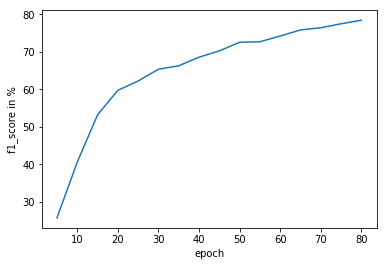

In [37]:
# plot f1_score of training result

ydata = score_per_time
xdata = np.zeros(len(ydata))
for i in range(0,num_train_f1score_details):
    xdata[i] = (i+1)*(epochs/num_train_f1score_details)
plt.plot(xdata,ydata*100)
plt.ylabel('f1_score in %')
plt.xlabel('epoch')
plt.show()

## Get accuracy for test and validation datasets

In [38]:
# Predict labels for test dataset   
predLabels, correctLabels = tag_dataset(test_batch)  

3452/3453 [============================>.] - ETA: 0s

In [39]:
# print the accuracy of test dataset

precision_test, recall_test, f1_test= compute_f1(predLabels, correctLabels, idx2Label)
print("Test-Data: Prec: %.3f%%, Rec: %.3f%%, F1: %.3f%%" % (precision_test*100, recall_test*100, f1_test*100))

Test-Data: Prec: 63.873%, Rec: 62.890%, F1: 63.378%


In [40]:
#   Performance on validation dataset        
predLabels, correctLabels = tag_dataset(dev_batch)        

3249/3250 [============================>.] - ETA: 0s

In [42]:
# print the accuracy of validation dataset

precision_dev, recall_dev, f1_dev = compute_f1(predLabels, correctLabels, idx2Label)
print("Validation-Data: Prec: %.3f%%, Rec: %.3f%%, F1: %.3f%%" % (precision_dev*100, recall_dev*100, f1_dev*100))

Validation-Data: Prec: 71.228%, Rec: 69.993%, F1: 70.605%
